In [1]:
import os, sys

fp_repo = '/Users/rfouyang/workspace/services/ds-fintech'
if fp_repo not in sys.path:
    sys.path.insert(0, fp_repo)

In [2]:
from pathlib import Path
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toad

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from util import woe_helper
from util import woe_mono
from util import stable_selection

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [6]:
fp_base = Path('/Users', 'rfouyang', 'workspace')
#fp_base = Path('C:\\', 'Users', 'USER', 'workspace')
fp_data = Path(fp_base, 'data', 'data.csv')

df_data = pd.read_csv(fp_data, index_col=None)

In [7]:
num_cols = ['Collateral_valuation', 'Age', 'Properties_Total', 'Amount', 'Term', 'Historic_Loans', 'Current_Loans', 'Max_Arrears']
cat_cols = ['Region', 'Area', 'Activity', 'Guarantor', 'Collateral', 'Properties_Status']
features = num_cols + cat_cols
label = 'Defaulter'

In [8]:
for c in cat_cols:
    df_data.loc[:, c] = df_data.loc[:, c].apply(lambda x: str(f"cat_{x}"))

In [9]:
woe = woe_helper.WOE()
woe.fit(df_data, label, exclude=['AppNo', label], method='dt')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.13it/s]


finish combiner fit
finish combiner transform


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.41it/s]


finish WOE fit


In [10]:
df_woe = woe.transform(df_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.77it/s]


# 稳定性筛选

In [38]:
from sklearn.linear_model import LogisticRegression

base_estimator = LogisticRegression(penalty='l1', solver='liblinear')

selector = stable_selection.StabilitySelection(
    base_estimator=base_estimator, lambda_name='C',
    lambda_grid=np.logspace(-5, -1, 50)
)

selector.fit(df_woe[features], df_woe[label])

In [39]:
df_fs_stable = pd.DataFrame({
    'feature' : features, 
    'stable_select' : selector.get_support(), 
    'stable_score': selector.stability_scores_.max(axis=1)})
df_fs_stable

,feature,stable_select,stable_score
0,Collateral_valuation,True,0.86
1,Age,True,1.00
2,Properties_Total,True,1.00
3,Amount,True,1.00
4,Term,True,1.00
5,Historic_Loans,True,1.00
6,Current_Loans,True,1.00
7,Max_Arrears,True,1.00
8,Region,True,1.00
9,Area,True,1.00


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Lambda / max(Lambda)', ylabel='Stability score'>)

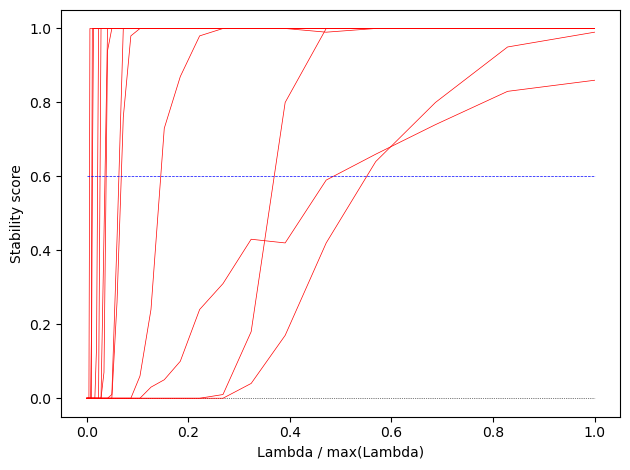

In [40]:
stable_selection.plot_stability_path(selector)

# VIF筛选

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
lst_item = list()
for k, c in enumerate(features):
    vif = variance_inflation_factor(df_woe[features], k)
    item = {'feature': c, 'vif_score': vif}
    lst_item.append(item)

In [49]:
df_fs_vif = pd.DataFrame(lst_item)
df_fs_vif

,feature,vif_score
0,Collateral_valuation,2.398628
1,Age,1.159514
2,Properties_Total,1.059383
3,Amount,1.707269
4,Term,1.263871
5,Historic_Loans,1.169254
6,Current_Loans,1.066556
7,Max_Arrears,1.020378
8,Region,1.690797
9,Area,1.229582


# 前后向筛选

In [44]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [45]:
estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
selector = RFE(estimator)
selector = selector.fit(df_woe[features], df_woe[label])

In [47]:
df_fs_rfe = pd.DataFrame({'feature' : features, "rfe_select" : selector.support_})
df_fs_rfe

,feature,rfe_select
0,Collateral_valuation,False
1,Age,True
2,Properties_Total,True
3,Amount,True
4,Term,True
5,Historic_Loans,True
6,Current_Loans,False
7,Max_Arrears,False
8,Region,True
9,Area,False


In [22]:
from boruta import BorutaPy

In [50]:
estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
selector = BorutaPy(estimator, n_estimators='auto', random_state=1, max_iter=10)
selector = selector.fit(df_woe[features].values, df_woe[label].values)

In [51]:
df_fs_bruta = pd.DataFrame({'feature' : features, "bruta_select" : selector.support_})
df_fs_bruta

,feature,bruta_select
0,Collateral_valuation,True
1,Age,True
2,Properties_Total,True
3,Amount,True
4,Term,True
5,Historic_Loans,True
6,Current_Loans,True
7,Max_Arrears,True
8,Region,True
9,Area,True


# 最大相关性最小冗余筛选

In [54]:
from skfeature.function.information_theoretical_based import MRMR

In [63]:
rank = MRMR.mrmr(df_woe[features].values, df_woe[label].values)

In [66]:
df_fs_mrmr = pd.DataFrame({'feature' : features, "mrmr_select" : rank})
df_fs_mrmr.sort_values(by='mrmr_select')

,feature,mrmr_select
10,Activity,0
8,Region,1
4,Term,2
12,Collateral,3
9,Area,4
0,Collateral_valuation,5
5,Historic_Loans,6
7,Max_Arrears,7
13,Properties_Status,8
6,Current_Loans,9


# 结合所有方法

In [68]:
df_fs = None
for df in [df_fs_stable, df_fs_vif, df_fs_rfe, df_fs_bruta, df_fs_mrmr]:
    if df_fs is None:
        df_fs = df
    else:
        df_fs = df_fs.merge(df, on='feature', how='left')
df_fs

,feature,stable_select,stable_score,vif_score,rfe_select,bruta_select,mrmr_select
0,Collateral_valuation,True,0.86,2.398628,False,True,5
1,Age,True,1.00,1.159514,True,True,11
2,Properties_Total,True,1.00,1.059383,True,True,12
3,Amount,True,1.00,1.707269,True,True,10
4,Term,True,1.00,1.263871,True,True,2
5,Historic_Loans,True,1.00,1.169254,True,True,6
6,Current_Loans,True,1.00,1.066556,False,True,9
7,Max_Arrears,True,1.00,1.020378,False,True,7
8,Region,True,1.00,1.690797,True,True,1
9,Area,True,1.00,1.229582,False,True,4
